In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm
from IPython.display import HTML, Javascript

In [570]:
def n_to_vect(n):
    canonic_base = np.zeros(47)
    canonic_base[n] = 1
    return canonic_base

In [240]:
def sigma (x):
    return 1/(1+ np.exp(-x))

In [241]:
def batch_iterator(X, y = None, batch_size = 64):

    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

In [242]:
class RBM():
    
    def __init__(self, n_hidden = 748, learning_rate = 0.1, batch_size = 10, n_iterations = 100):
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.lr = learning_rate
        self.n_hidden = n_hidden

    def _initialize_weights(self, X):
        n_visible = X.shape[1]
        self.W = np.random.normal(scale=0.1, size=(n_visible, self.n_hidden))
        self.v0 = np.zeros(n_visible)       # Bias visible
        self.h0 = np.zeros(self.n_hidden)   # Bias hidden
    
    def _mean_hiddens(self, v):
        #Computes the probabilities P(h=1|v). 
        
        return sigma(v.dot(self.W) + self.h0)
    
    def _sample_hiddens(self, v):
        #Sample from the distribution P(h|v).
        
        p = self._mean_hiddens(v)
        return self._sample(p)
    
    def _sample_visibles(self, h):
        #Sample from the distribution P(v|h).
        
        p = sigma(h.dot(self.W.T) + self.v0)
        return self._sample(p)
    
    def gibbs(self, v):
        #Perform one Gibbs sampling step.
        
        h_ = self._sample_hiddens(v)
        v_ = self._sample_visibles(h_)

        return v_
    
    def _sample(self, X):
        return X > np.random.random_sample(size = X.shape)
    
    def CD1(self, X):

        self._initialize_weights(X)

        self.training_errors = []
        self.training_reconstructions = []
        
        for _ in tqdm(range(self.n_iterations)):
            batch_errors = []
            for batch in batch_iterator(X, batch_size = self.batch_size):
                
                # Positive phase
                positive_hidden = self._mean_hiddens(batch)
                positive_associations = batch.T.dot(positive_hidden)
                hidden_states = self._sample_hiddens(batch)
                
                # Negative phase
                negative_visible = self._sample_visibles(hidden_states)
                negative_hidden = self._mean_hiddens(negative_visible)
                negative_associations = negative_visible.T.dot(negative_hidden)
                
                self.W  += self.lr * (positive_associations - negative_associations)
                self.h0 += self.lr * (positive_hidden.sum(axis = 0) - negative_hidden.sum(axis = 0))
                self.v0 += self.lr * (batch.sum(axis = 0) - negative_visible.sum(axis = 0))

                batch_errors.append(np.mean((batch - negative_visible) ** 2))

            self.training_errors.append(np.mean(batch_errors))
            # Reconstruct a batch of images from the training set
            self.training_reconstructions.append(self.reconstruct(X[:25])) 

    def reconstruct(self, X):
        positive_hidden = sigma(X.dot(self.W) + self.h0)
        hidden_states = self._sample(positive_hidden)
        negative_visible = sigma(hidden_states.dot(self.W.T) + self.v0)
        return negative_visible

In [590]:
train_data = pd.read_csv('emnist-balanced-train.csv', delimiter = ',')
test_data = pd.read_csv('emnist-balanced-test.csv', delimiter = ',')

dim = 28

In [562]:
data = pd.read_csv('emnist-bymerge-train.csv', delimiter = ',')

In [563]:
print(len(data))

697931


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:52<00:00,  2.10s/it]


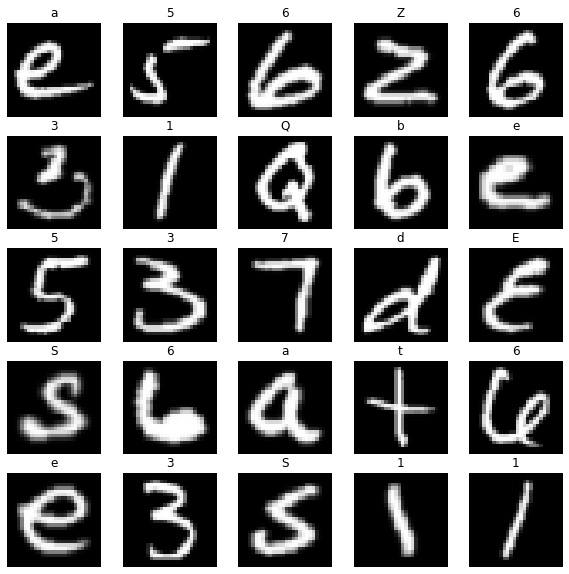

In [564]:
plt.figure(figsize=(10, 10))
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

cnt = 0
for n in tqdm(range(25)):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow((np.asfarray(data)[n,1:]/255).reshape((28, 28)).T, cmap='gray')
    plt.title(LABELS[int(np.asfarray(data)[n,0])])
    plt.axis('off')
        
plt.show()
plt.close()

<BarContainer object of 47 artists>

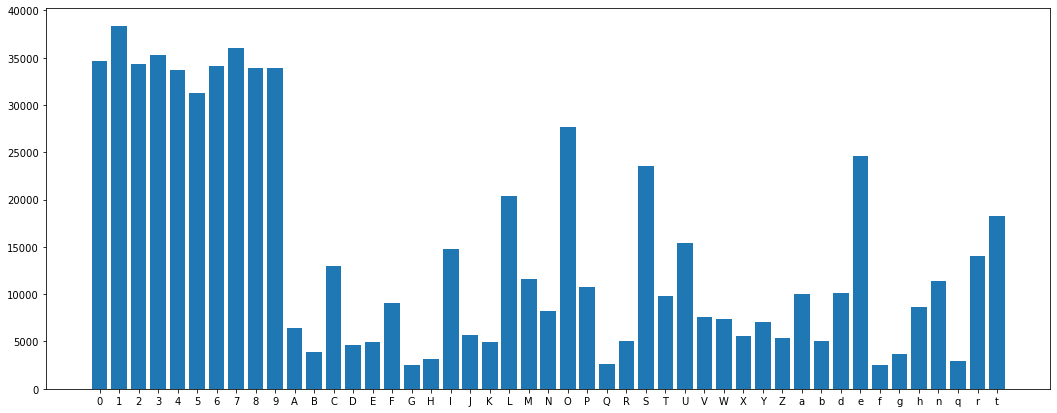

In [565]:
from collections import Counter

c = Counter(np.asarray(data)[:,0])
x = sorted(c.items())

value = [b for a,b in x]

plt.figure(figsize=(18, 7))
plt.bar(LABELS[:len(value)], value)

In [591]:
train_label = np.array(train_data)[:,1:]
#test_label = np.array(test_data)[:,1:]

train_set = (np.asfarray(train_data)[:,1:]/255)
#test_set = (np.asfarray(test_data)[:,1:]/255)

#train_label = [n_to_vect(x) for x in train_label]
#test_label = [n_to_vect(x) for x in test_label]

In [592]:
for i in range(len(train_set)):
    train_set[i] = [0 if x<0.4 else 1 for x in train_set[i]]
    
#for i in range(len(train_set)):
#    test_set[i] = [0 if x<0.4 else 1 for x in test_set[i]]

In [604]:
rbm = RBM(n_hidden = dim*dim, n_iterations = 100, batch_size = 1, learning_rate = 0.001)
rbm.CD1(np.array(train_set[101], ndmin = 2))

gen_imgs = rbm.training_reconstructions

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.69it/s]


In [605]:
(np.asfarray(train_data)[:,1:]/255)[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01568627,
       0.01568627, 0.01176471, 0.01176471, 0.01176471, 0.01568627,
       0.01568627, 0.01568627, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00784314, 0.03529412, 0.1254902 ,
       0.14509804, 0.14509804, 0.14509804, 0.14509804, 0.14509804,
       0.14509804, 0.2       , 0.44705882, 0.49019608, 0.37254

In [606]:
gen_imgs[1].shape

(1, 784)

In [607]:
fig = plt.figure()

x = [img.reshape((28,28)).T for img in gen_imgs]
im = plt.imshow(x[0], animated = False, cmap = 'gray')
plt.close()

def updatefig(i):
    im.set_array(x[i])
    return im,

anim = animation.FuncAnimation(fig = fig, func = updatefig, frames = len(x) if len(x)<60 else 60, interval = 50, blit = True)
display(HTML(anim.to_jshtml(default_mode = "once")))

In [608]:
rbm = RBM(n_hidden = 784, n_iterations = 100, batch_size = 25, learning_rate = 0.001)
rbm.CD1(train_set[:500])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


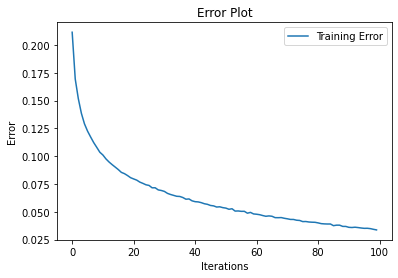

In [609]:
# Training error plot
training, = plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label = "Training Error")
plt.legend(handles = [training])
plt.title("Error Plot")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

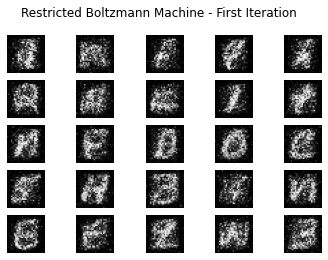

In [611]:
# Get the images that were reconstructed during training
gen_imgs = rbm.training_reconstructions

# Plot the reconstructed images during the first iteration
fig, axs = plt.subplots(5, 5)
plt.suptitle("Restricted Boltzmann Machine - First Iteration")
cnt = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs[0][cnt].reshape((28, 28)).T, cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("rbm_first.png")
plt.show()
plt.close()

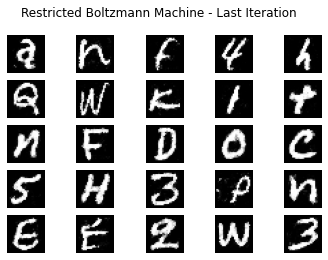

In [612]:
# Plot the images during the last iteration
fig, axs = plt.subplots(5, 5)
plt.suptitle("Restricted Boltzmann Machine - Last Iteration")
cnt = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs[-1][cnt].reshape((28, 28)).T, cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("rbm_last.png")
plt.show()
plt.close()

## Image Reconstruction using RBM

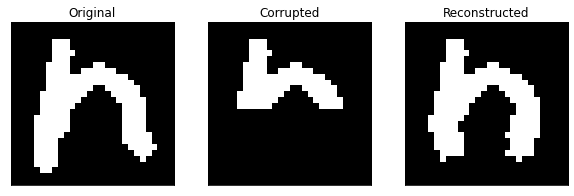

In [617]:
# Pick another random image and set some parts of the image to zero.
im_ind = 700
miss = 15
X_missing = test_set[im_ind].copy().reshape(28,28)
X_missing[:,miss:] = 0

# Image Reconstruction
k_iter = 200 # Number of Gibbs iterations
alpha = 1.1 # Decay factor

X_recon = np.zeros((28,28-miss)) # Array to store the reconstruction

b = X_missing.copy().reshape(-1)

for i in range(k_iter):
    b = rbm.gibbs(b)
    X_recon += alpha**(i) * b.reshape(28,28)[:,miss:]
    b.reshape(28,28)[:,:miss] = X_missing[:,:miss]

# Apply a threshold and complete the image
X_recon = np.where(X_recon > 0.5*np.max(X_recon), 1, 0)
X_complete = X_missing.copy()
X_complete[:,miss:] = X_recon

# Plot the figures
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(test_set[im_ind].reshape(28, 28).T, cmap = 'gray')
ax[0].set_title('Original')
ax[1].imshow(X_missing.T, cmap ='gray')
ax[1].set_title('Corrupted')
ax[2].imshow(X_complete.reshape(28,28).T, cmap = 'gray')
ax[2].set_title('Reconstructed')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()